## ✏️ Проект 1. Угадай знаменитость 


импортируем бибилиотеки


In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import time
import glob
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import cv2

%matplotlib inline

In [8]:
path_train = 'data/train/'
path_valid = 'data/valid/'
# создаем список и словарь меток
sub_path = ['bill_gates', 'elon_mask', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']
dict_target = {'bill_gates' : 0,
              'elon_mask' : 1,
              'jeff_bezos' : 2,
              'mark_zuckerberg' : 3,
              'steve_jobs' : 4}

Создаем класс Dataset


In [9]:
class CustomDataset(Dataset):
    def __init__(self, train_flag = 'train', path_train = path_train, path_valid = path_valid):
        if train_flag == 'train':
            self.imgs_path = path_train
        elif train_flag == 'val':
            self.imgs_path = path_valid
        self.data = []
        # задаем размер изображения для нейронной сети
        self.img_dim = (64, 64)
        self.classes = sub_path

       # Разделим выборку на обучающую и валидационную
        if train_flag == 'train':
            for img_path in sub_path:
                for image_name in glob.glob(self.imgs_path + img_path + '/*.jpg'):
                       self.data.append([image_name, dict_target[img_path]])                 
                
          
        elif train_flag == 'val':
            for img_path in sub_path:
                for image_name in glob.glob(self.imgs_path + img_path + '/*.jpg'):
                       self.data.append([image_name, dict_target[img_path]])
         
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]

        # Мы используем opencv, чтобы загрузить изображение и изменить его размер до необходимого размера
        img = cv2.imread(img_path)
        img = img[:, :, ::-1]
        img = cv2.resize(img, self.img_dim,  cv2.INTER_AREA)

        
        class_id = class_name
        img_tensor = torch.from_numpy(img)

        # Приведем скейлинг изображения: переведем пиксели от 0 до 255 к формату от 0 до 1 
        img_tensor = img_tensor/255
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

Параметр train_flag класса CustomDataset позволяет нам выбирать между обучающей и тестовой выборкой


In [11]:
# создаем обучающий и валидационный датасеты
train_data = CustomDataset()
val_data = CustomDataset('val')

# разобьем обучающий датасет на тренировочный и тестовый
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_data, [train_size, test_size])

# задаем размер батча
batch_size = 24

# создаем даталоудеры
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [ ]:
# проверим размер данных
train_data[0][0].size()

torch.Size([3, 64, 64])

Посмотрим на размер train_data с помощью метода len()


In [13]:
train_data.__len__()

2400

Отрисуем один батч картинок, загруженных с помощью DataLoader()


In [14]:
X_train, y_train = next(iter(train_loader))
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))

In [15]:
classes = train_data.classes
classes

['bill_gates', 'elon_mask', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

['bill_gates', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs', 'steve_jobs', 'jeff_bezos', 'steve_jobs', 'bill_gates', 'bill_gates', 'jeff_bezos', 'bill_gates', 'steve_jobs', 'mark_zuckerberg', 'jeff_bezos', 'steve_jobs', 'jeff_bezos', 'mark_zuckerberg', 'bill_gates', 'steve_jobs', 'mark_zuckerberg', 'steve_jobs', 'jeff_bezos', 'jeff_bezos', 'mark_zuckerberg']


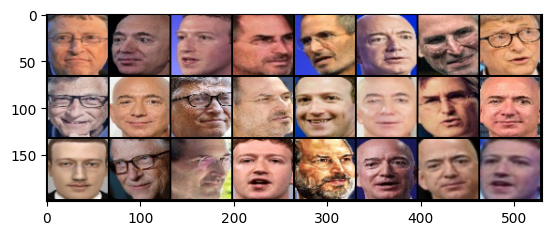

In [16]:
print([classes[i] for i in y_train])
plt.imshow(img)

## Загрузка модели

Мы будем использовать VGG16 в качестве предобученной сети


In [17]:
from torchvision.models import vgg16

In [ ]:
model = vgg16(pretrained = True)
print(model)

c:\Users\Ghost\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ghost\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Ghost/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:15<00:00, 35.6MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Это значит, что мы будем использовать уже обученные веса данной нейронной сети

Заморозка слоев VGG16 сети

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
# Посмотрим, сколько нейронов подается на вход выходному слою классификатора
n_neurons = model.classifier[-1].in_features 
print(n_neurons)

# Заменим этот слой на новый, выходное количество нейронов которого соотвествует нашей задачи классификации
num_classes = 5
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

4096


Разморозим классификатор модели, мы будем заново обучать его полностью

In [21]:
for index, param in enumerate(model.classifier.parameters()):
    param.requires_grad = True

Переносим модель на видеокарту.
В качестве функции потерь используем кроссэнтропию.
Используем оптимизатор Adam.

In [ ]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

True


## Обучение модели

Для удобства создадим словарь даталоадеров:

In [23]:
dataloaders = {'train': train_loader,
               'test' : test_loader,
               'val': val_loader}

In [24]:
def train_model(model, device, dataloaders, criterion, optimizer, batch_size, num_epochs=24):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # На каждой эпохе происходит обучение и валидация 
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем лосс
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
                # посмотрим на статистики на каждых 10 батчах
                if batch%10 == 0 and phase == "train":
                  print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                  batch, current_loss/(batch_size*batch), 100*current_corrects/(batch_size*batch)))

            if phase == 'train':
                len_dataset = train_size
            else:
                len_dataset = test_size
            epoch_loss = current_loss / len_dataset 
            epoch_acc = current_corrects.double() / len_dataset 

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [ ]:
person_model = train_model(model, device, dataloaders, criterion, optimizer, batch_size = batch_size)

Epoch 0/23
----------
Batch 10, Train Loss:1.9163, Train ACC:38.3333
Batch 20, Train Loss:1.6334, Train ACC:49.5833
Batch 30, Train Loss:1.5333, Train ACC:55.6944
Batch 40, Train Loss:1.3099, Train ACC:61.7708
Batch 50, Train Loss:1.1983, Train ACC:65.8333
Batch 60, Train Loss:1.1410, Train ACC:67.8472
Batch 70, Train Loss:1.0775, Train ACC:70.5952
Batch 80, Train Loss:1.0460, Train ACC:71.8750
train Loss: 1.0460 Acc: 0.7188
test Loss: 0.4010 Acc: 0.9167
Epoch 1/23
----------
Batch 10, Train Loss:0.7089, Train ACC:85.4167
Batch 20, Train Loss:0.6125, Train ACC:87.7083
Batch 30, Train Loss:0.5028, Train ACC:89.3056
Batch 40, Train Loss:0.5987, Train ACC:88.5417
Batch 50, Train Loss:0.7264, Train ACC:87.2500
Batch 60, Train Loss:0.7290, Train ACC:87.1528
Batch 70, Train Loss:0.6762, Train ACC:87.5595
Batch 80, Train Loss:0.6481, Train ACC:87.8125
train Loss: 0.6481 Acc: 0.8781
test Loss: 0.2638 Acc: 0.9271
Epoch 2/23
----------
Batch 10, Train Loss:0.5241, Train ACC:91.6667
Batch 20, Tra

## Визуализация модели

In [26]:
def visualize_model(model, num_images=24):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure(figsize=(15, 15))

    if use_gpu:
      device = 'cuda'
    else:
      device = 'cpu'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Проверим нашу модель на валидационных данных

In [27]:
current_loss = 0.0
current_corrects = 0
batch = 0
person_model.eval()

# Проходим по данным
for inputs, labels in dataloaders['val']:
    batch += 1
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        # Получаем прогноз модели и считаем лосс
        outputs = person_model(inputs)
        _, preds = torch.max(outputs, 1)
        labels = labels.squeeze(-1)
        loss = criterion(outputs, labels)
        
        # считаем статистики
    current_loss += loss.item() * inputs.size(0)
    current_corrects += torch.sum(preds == labels)
                
                
            
epoch_loss = current_loss / CustomDataset('val').__len__()
epoch_acc = current_corrects.double() / CustomDataset('val').__len__()


In [28]:
print(epoch_loss)
print(epoch_acc.item()*100)

1.3089512889912935
97.50000000000001


accuracy на валидационных данных 97,5%, что удовлетворяет условию задачи

Проверка полноты валидации

In [29]:
batch * batch_size

720

In [30]:
CustomDataset('val').__len__()

720

Визуализация валидации

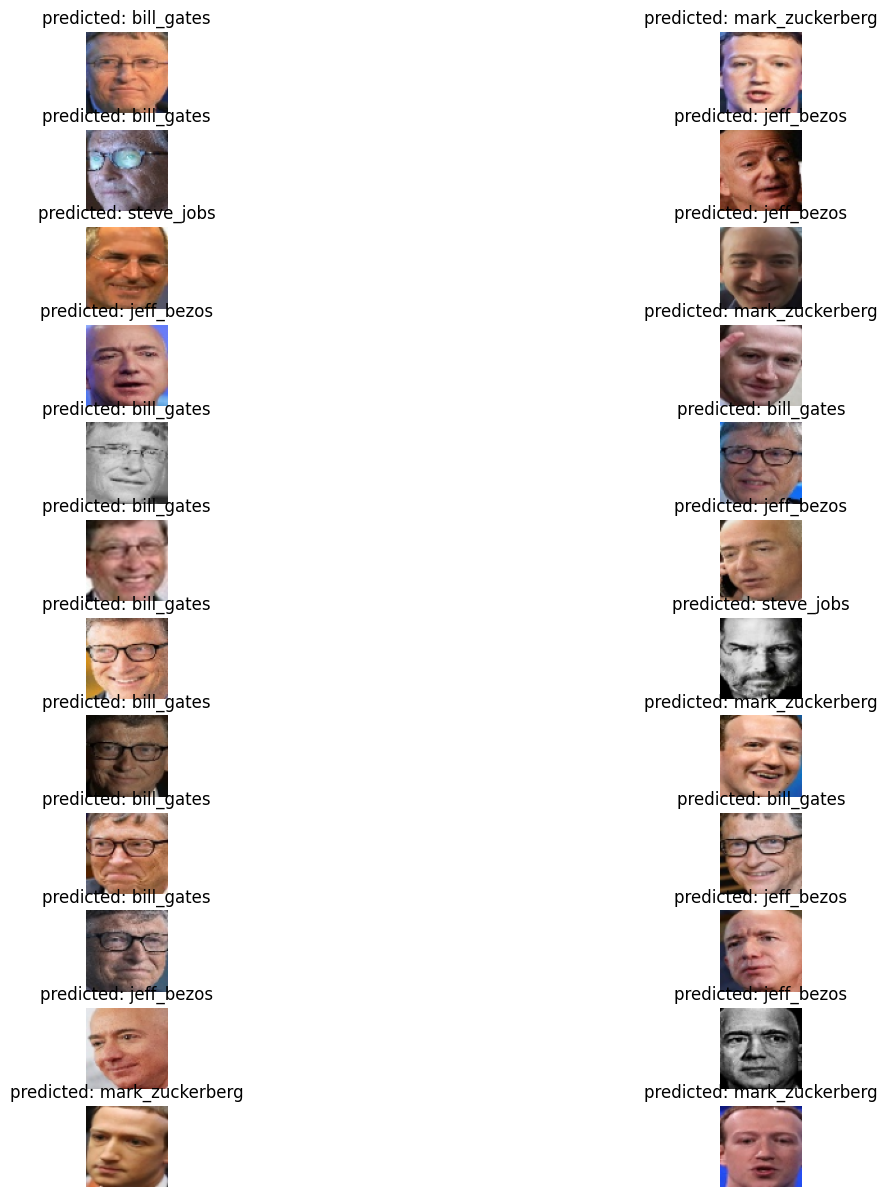

In [ ]:
visualize_model(person_model)
plt.show()

Из 24 примеров на валидации ошибок нет

### сохраняем модель


In [ ]:
torch.save(person_model, './person_model')

# Выводы


Для задач классификации существует много предобученных моделей. Их использование намного упрощает и ускоряет процесс разработки моделей без потери качества. В данной работе мы использовали довольно простую нейронную сеть VGG16. Мы переобучили полностью ее классификатор. Это сэкономило много времени и машинных ресурсов. А качество классификации осталось очень высоким. На самом деле, для пяти классов сеть такой сложности не нужна. Достаточно 4-5 слоев свертки и 3-4 слоев классификатора из полносвязных слоев. Но даже такая простая модель обучается дольше в два раза, чем готовая предобученная. Поэтому использование готовых предобученных сетей дает ощутимый выигрыш и весьма целесообразно.